In [1]:
%matplotlib inline
import os,sys,random

from parabola import ParabolicRegion as Parabola
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from igmm import IGMM

In [2]:
def get_random_motor_set(system, n_samples):
    n_motor = system.n_motor
    raw_rnd_data = np.random.random((n_samples, n_motor))

    min_values = system.min_motor_values
    max_values = system.max_motor_values

    min_values = np.array(n_samples * [np.array(min_values)])
    max_values = np.array(n_samples * [np.array(max_values)])
    motor_commands = min_values + raw_rnd_data * (max_values - min_values)
    return motor_commands

def load_h5(file_name, system=None):
    # Keeping support to old datamanager files
    motor = pd.read_hdf(file_name, 'motor').as_matrix()
    sensor = pd.read_hdf(file_name, 'sensor').as_matrix()
    return motor, sensor

def evaluate_model(system, model, sensor_evaluation, axes=None):
    if axes is not None:
        plt.sca(axes)
        plt.hold(True)
    n_samples = sensor_evaluation.shape[0]
    x_dims = range(system.n_motor)
    y_dims = range(system.n_motor,system.n_motor+system.n_sensor)
    total_norm_error = 0.
    for i in range(n_samples):
        action = model.infer(x_dims,
                             y_dims,
                            sensor_evaluation[i,:])
        system.set_action(action)
        system.executeMotorCommand()
        if axes is not None:
            plt.scatter(sensor_evaluation[i,0],sensor_evaluation[i,1], marker = 'o', s = 3., color = 'b')
            plt.scatter(system.sensor_out[0],system.sensor_out[1],marker = 'x', s = 12., color = 'r')
        total_norm_error += np.linalg.norm(sensor_evaluation[i,:]-system.sensor_out)
    return total_norm_error/float(n_samples)

In [3]:
batch_size = 15
n_batches = 10

np.random.seed(123)

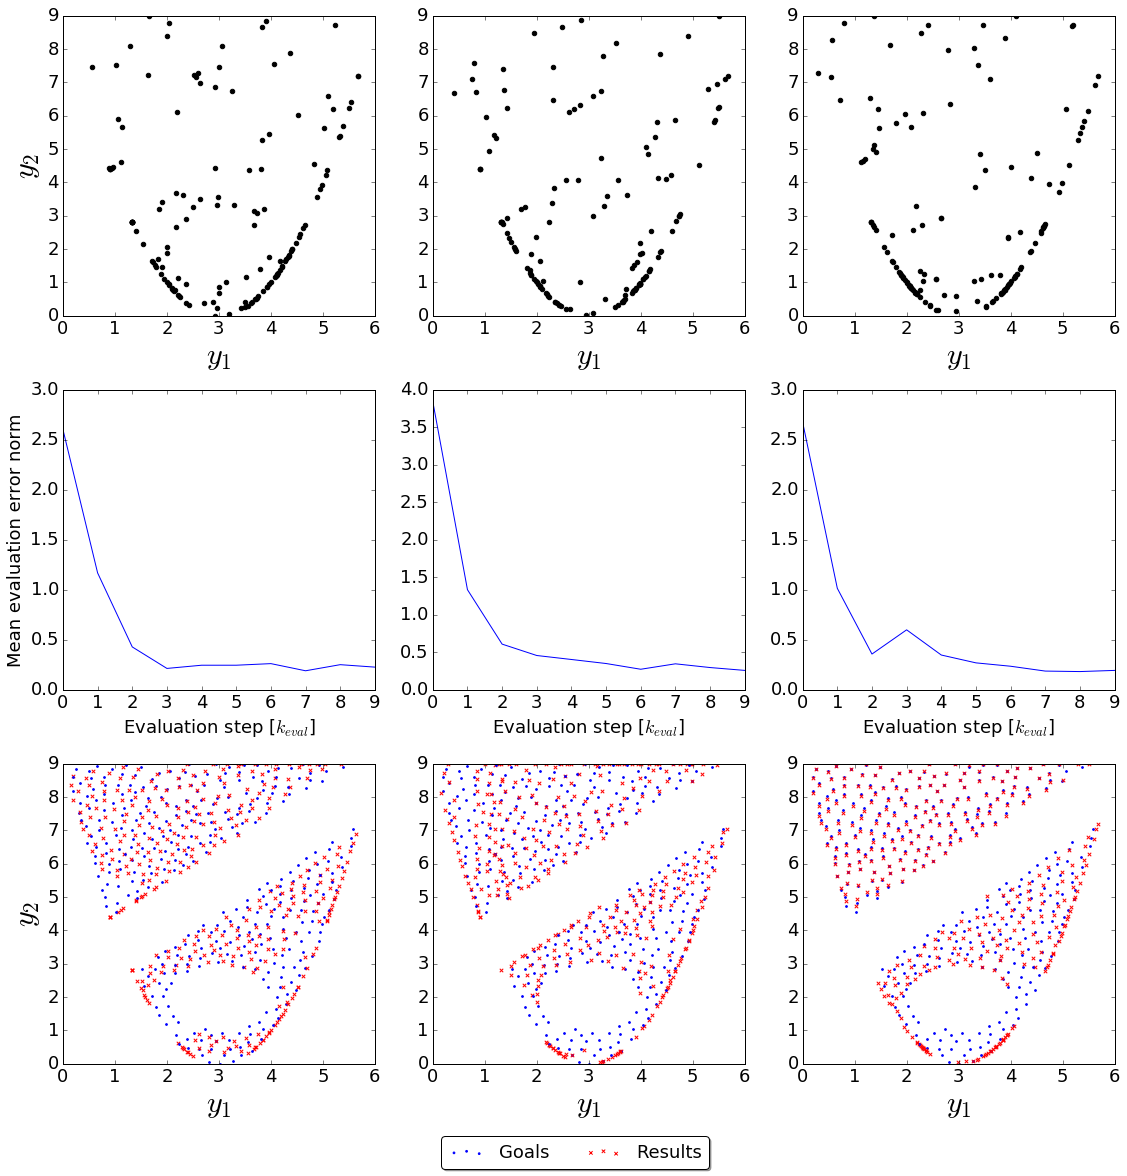

In [4]:
# Results Container
matplotlib.rcParams['figure.figsize'] = (16.0, 16.0)
matplotlib.rcParams.update({'font.size': 18})
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'30'}

fig1,ax1 = plt.subplots(3,3)

for ii in range(3):
    ### System and Model
    system = Parabola()
    model = IGMM(min_components=3,
                 max_step_components=7,
                 max_components=10,
                 forgetting_factor=0.2)

    motor_evaluation, sensor_evaluation = load_h5('../parabola_dataset_2.h5')

    ### Train
    eval_evo = np.zeros((n_batches,))
    train_data_w = []
    for i in range(n_batches):
        motor_data = get_random_motor_set(system, batch_size)
        sensor_data = np.zeros((batch_size,system.n_sensor))
        for j in range(batch_size):
            system.set_action(motor_data[j,:])
            system.executeMotorCommand()
            sensor_data[j,:] = system.sensor_out
        train_data = np.concatenate((motor_data,sensor_data), axis=1)
        model.train(train_data)
        eval_evo[i] = evaluate_model(system, model, sensor_evaluation)
        train_data_w += [sensor_data]

    ### Plot
    plt.sca(ax1[0,ii])
    plt.hold(True)
    for batch in train_data_w:
        plt.scatter(batch[:,0],batch[:,1], marker = 'o', color = 'k')
    ax1[0,ii].set_xlim([0,6])
    ax1[0,ii].set_ylim([0,9])

    plt.xlabel('$y_1$',**axis_font)

    plt.sca(ax1[1,ii])
    plt.plot(eval_evo)
    plt.xlabel('Evaluation step [$k_{eval}$]')

    plt.sca(ax1[2,ii])
    plt.hold(True)
    evaluate_model(system, model, sensor_evaluation,axes=ax1[2,ii])
    plt.xlabel('$y_1$',**axis_font)

    ax1[2,ii].set_xlim([0,6])
    ax1[2,ii].set_ylim([0,9])

plt.sca(ax1[0,0])
plt.ylabel('$y_2$',**axis_font)
plt.sca(ax1[1,0])
plt.ylabel('Mean evaluation error norm')
plt.sca(ax1[2,0])
plt.ylabel('$y_2$',**axis_font)
lgd = plt.legend(['Goals','Results'],\
                 ncol=2,loc='lower right', fontsize=18, bbox_to_anchor=(2.1, -0.38),
                 fancybox=True, shadow=True)
fig1.tight_layout(h_pad=0.5)

In [ ]:
# fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/2017 CCIA Regression Problem with IGMM/images/reg.eps',\
#             format='eps', dpi=1000, transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')